# ISB-CGC Community Notebooks



```
Title:   How to make t-SNE and UMAP plots 
Author:  David L Gibbs
Created: 2019-10-15
Purpose: Demonstrate how to perform dimension reduction with PCA, t-SNE, and UMAP, and create visualizations.
Notes:
```

In this notebook we will cover how to apply dimension reduction to a matrix using PCA, t-SNE, and UMAP techniques.

These methods are very common in single cell RNA-seq analysis, but can be applied to any type of data. Here we will be using TCGA gene expression data from two studies, KIRC (kidney cancer) and MESO (skin cancer).

The final result is a set of vectors that approximate the a low dimensional representation of the data, and some plots showing the low dimensional representation. In single cell RNA-seq, this is the now classic cluster of cell types plot, where each cluster is a type of cells.

In this work, we'll see if the two tissue types separate.

This data was created by starting with the TCGA MESO and KICH data sets and taking a random sample of high variance genes within each study.  So we should get a matrix with some high variance genes in MESO, and some high variance genes in KICH, but without a lot of overlap.  Hopefully, enough differences will be present to separate the two groups, but it's not guaranteed.

# Auth

In [1]:
# first we'll log in, in order to access a project bucket.

!gcloud auth login

# in order to authenticate and get a credentials token use the following:
# !gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=mYzIsCgHGFyW1r4edj0mp4IwfsmyLNE3t4ccY4xrmEk&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/sAEfwOD0wNyGa_2VLfwmaz25GPiJyn9CsfVto5oUwTlSlvD7eEGaBHk
If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [dgibbs@systemsbiology.org].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud alph


---


# Software install

First we need to install scanpy, the python library that streamlines these types of analysis.

The documentation on scanpy can be found at: 
https://icb-scanpy.readthedocs-hosted.com/en/stable/index.html

In [7]:
!pip3 install scanpy

     |████████████████████████████████| 1.9MB 9.4MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 3.6MB 52.5MB/s 
     |████████████████████████████████| 20.2MB 1.6MB/s 
  Found existing installation: llvmlite 0.29.0
    Uninstalling llvmlite-0.29.0:
      Successfully uninstalled llvmlite-0.29.0
  Found existing installation: numba 0.40.1
    Uninstalling numba-0.40.1:
      Successfully uninstalled numba-0.40.1


Now that we have our software installed, we can import the libraries and read in some data

In [0]:
import scanpy as sc
import pandas as pd

# Reading in data

I have some data already in a bucket.. we'll copy that over, and read it into scanpy making what's called an 'anndata' object.

The Anndata (annotated data) object is really cool:  https://anndata.readthedocs.io/en/stable/

It's a matrix (X) with pandas dataframes attached to it's columns (var) and rows (obs). Additionally there's an unstructured list of data (uns).

See the image below (taken from the anndata docs page).

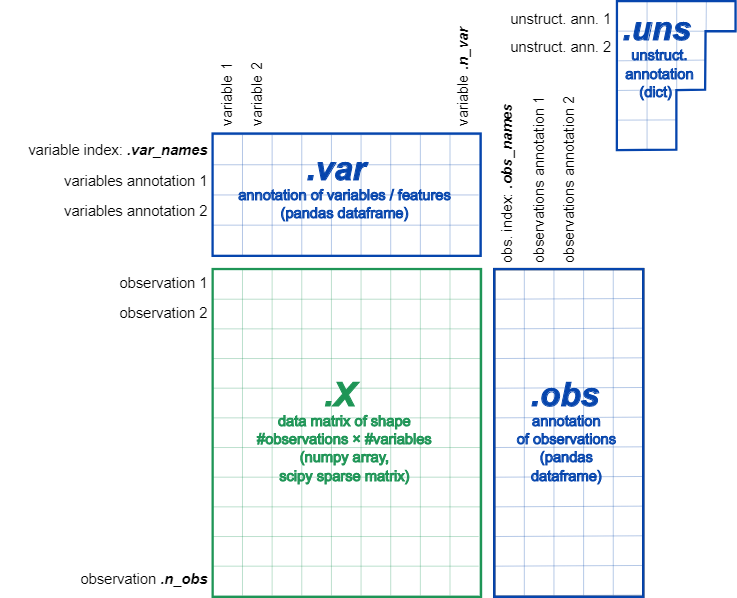


In [85]:
# we're going to work with a gene expression matrix (tcga_expr_data_no_header.tsv)
# a table of gene names (geneids.tsv)
# and a table of tissue labels (data_labels.tsv)

!gsutil -m cp gs://tcga_expr_data_bucket/* .

Copying gs://tcga_expr_data_bucket/data_labels.tsv...
Copying gs://tcga_expr_data_bucket/tcga_expr_data.tsv...
Copying gs://tcga_expr_data_bucket/tcga_expr_data_no_header.tsv...
Copying gs://tcga_expr_data_bucket/geneids.tsv...
/ [4/4 files][  1.1 MiB/  1.1 MiB] 100% Done                                    
Operation completed over 4 objects/1.1 MiB.                                      


In [0]:
!head data_labels.tsv

ID	Study
fe8b28e6.e019.475a.bfd7.d5880a6967fe	MESO
e0848b76.e86a.4564.a5ae.f3daee48224d	MESO
X3d627ad5.9b51.4caf.aa2c.645a184e7f30	MESO
da195984.1a09.46d9.93c3.544cc93ae437	MESO
c635ded2.c7a2.4d60.b9a1.c2d933e89b1c	MESO
X9af6ff5c.fc37.4bf8.be98.af08fd41f8c9	MESO
X03117c7b.8e3b.4f78.bf72.641902abd90c	MESO
X8112112b.b75b.4dab.8185.1074f5d4bd0d	MESO
ab84c983.7fa3.4b44.9ed3.12654fb366a4	MESO


In [0]:
# scanpy is expecting the matrix to have samples (or cells) in rows and genes in columns
# also the expectation is that the first column will be sample IDs, and that gene names
# will be supplied separately.

adata = sc.read_csv('tcga_expr_data_no_header.tsv',  delimiter='\t', first_column_names=True )

# if you were reading the output of cellranger, there's a separate genes file that's read in.
# adata = sc.read_mtx( 'cellranger directory' )

In [0]:
# to make the IDs the table index
labels = pd.read_csv('data_labels.tsv', delimiter='\t',  index_col=0)

In [0]:
genes = pd.read_csv('geneids.tsv', delimiter='\t', index_col=6)

In [0]:
labels[0:5]


,Study
ID,
fe8b28e6.e019.475a.bfd7.d5880a6967fe,MESO
e0848b76.e86a.4564.a5ae.f3daee48224d,MESO
X3d627ad5.9b51.4caf.aa2c.645a184e7f30,MESO
da195984.1a09.46d9.93c3.544cc93ae437,MESO
c635ded2.c7a2.4d60.b9a1.c2d933e89b1c,MESO


In [76]:
genes[0:5]

,ID,EnsemblTranscript,EnsemblGene,VegaGeneID,VegaTranscriptID,SymbolNum,Entrez,GeneFunction,Other
Symbol,,,,,,,,,
TXNIP,165860,ENST00000582401.5,ENSG00000265972.5,OTTHUMG00000013755.6,OTTHUMT00000038547.3,TXNIP-001,2926,protein_coding,NaN
FKBP9,95425,ENST00000490776.3,ENSG00000122642.10,OTTHUMG00000097847.3,-,FKBP9-201,2699,protein_coding,NaN
OAZ1,174568,ENST00000592787.2,ENSG00000104904.12,OTTHUMG00000178459.10,OTTHUMT00000451282.2,OAZ1-009,857,retained_intron,NaN
WARS,17417,ENST00000358655.8,ENSG00000140105.17,OTTHUMG00000171572.3,OTTHUMT00000414235.1,WARS-004,2466,protein_coding,NaN
GABARAP,161755,ENST00000577035.5,ENSG00000170296.9,OTTHUMG00000102156.3,OTTHUMT00000440079.1,GABARAP-005,762,protein_coding,NaN


In [0]:
adata.obs[0:5]

""
fe8b28e6.e019.475a.bfd7.d5880a6967fe
e0848b76.e86a.4564.a5ae.f3daee48224d
X3d627ad5.9b51.4caf.aa2c.645a184e7f30
da195984.1a09.46d9.93c3.544cc93ae437
c635ded2.c7a2.4d60.b9a1.c2d933e89b1c


In [0]:
# then here we can annotate adata.obs
adata.obs['Study'] = labels

In [0]:
# here we bring in the gene ids / names
adata.var = genes

In [0]:
# just to makes sure all are unique
adata.var_names_make_unique()

In [80]:
# so we have a matrix with 178 samples by 400 genes
adata

AnnData object with n_obs × n_vars = 178 × 400 
    obs: 'Study'
    var: 'ID', 'EnsemblTranscript', 'EnsemblGene', 'VegaGeneID', 'VegaTranscriptID', 'SymbolNum', 'Entrez', 'GeneFunction', 'Other'
    uns: 'pca', 'neighbors', 'Study_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [0]:
adata.obs[0:5]

,Study
fe8b28e6.e019.475a.bfd7.d5880a6967fe,MESO
e0848b76.e86a.4564.a5ae.f3daee48224d,MESO
X3d627ad5.9b51.4caf.aa2c.645a184e7f30,MESO
da195984.1a09.46d9.93c3.544cc93ae437,MESO
c635ded2.c7a2.4d60.b9a1.c2d933e89b1c,MESO


In [81]:
adata.var[0:5]

,ID,EnsemblTranscript,EnsemblGene,VegaGeneID,VegaTranscriptID,SymbolNum,Entrez,GeneFunction,Other
Symbol,,,,,,,,,
TXNIP,165860,ENST00000582401.5,ENSG00000265972.5,OTTHUMG00000013755.6,OTTHUMT00000038547.3,TXNIP-001,2926,protein_coding,NaN
FKBP9,95425,ENST00000490776.3,ENSG00000122642.10,OTTHUMG00000097847.3,-,FKBP9-201,2699,protein_coding,NaN
OAZ1,174568,ENST00000592787.2,ENSG00000104904.12,OTTHUMG00000178459.10,OTTHUMT00000451282.2,OAZ1-009,857,retained_intron,NaN
WARS,17417,ENST00000358655.8,ENSG00000140105.17,OTTHUMG00000171572.3,OTTHUMT00000414235.1,WARS-004,2466,protein_coding,NaN
GABARAP,161755,ENST00000577035.5,ENSG00000170296.9,OTTHUMG00000102156.3,OTTHUMT00000440079.1,GABARAP-005,762,protein_coding,NaN


In [41]:
# the data matrix is stored in X as a numpy array

adata.X[1:5][1:5]

array([[ 507.02  ,   37.8789,   60.387 , ...,   17.5988,   20.761 ,
        1399.13  ],
       [ 122.317 ,  119.101 ,   93.807 , ...,   55.1742,   13.8157,
         722.68  ],
       [ 581.908 ,   57.2887,   47.5264, ...,   11.9343,   13.5899,
         920.561 ]], dtype=float32)

# Computing dimension reductions

In [0]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [0]:
sc.tl.pca(adata, n_comps=21)

In [0]:
sc.pp.neighbors(adata)

In [45]:
sc.tl.tsne(adata, n_pcs=4, perplexity=30, early_exaggeration=12, learning_rate=1000)

In [0]:
sc.tl.umap(adata)

#Accessing the reduced dimensions

In [60]:
adata.uns['pca']

{'variance': array([115.83537  ,  63.47404  ,  28.734423 ,  18.461145 ,  12.111868 ,
          9.867868 ,   8.307353 ,   7.152288 ,   6.8425746,   5.562655 ,
          5.0288305,   4.685403 ,   4.3127637,   4.0639367,   4.0355854,
          3.811512 ,   3.2536268,   2.9959486,   2.8557818,   2.7770097,
          2.466013 ], dtype=float32),
 'variance_ratio': array([0.2895891 , 0.15868548, 0.07183623, 0.04615297, 0.03027974,
        0.02466973, 0.02076843, 0.01788076, 0.01710648, 0.01390667,
        0.01257211, 0.01171353, 0.01078193, 0.01015987, 0.01008899,
        0.0095288 , 0.00813409, 0.00748989, 0.00713947, 0.00694254,
        0.00616505], dtype=float32)}

In [62]:
adata.obsm['X_pca']

array([[-1.0563870e+01,  1.0456644e+00,  6.6381818e-01, ...,
         6.9732338e-01,  1.7263010e+00,  1.2540044e+00],
       [-8.7992353e+00,  1.0998660e+01,  2.8111336e+00, ...,
        -1.4739747e+00, -5.8063161e-02, -2.1417284e+00],
       [-1.0449380e+01,  7.8517425e-01, -1.4215187e+00, ...,
        -2.2144916e+00,  2.6720652e-01, -2.1770555e-01],
       ...,
       [ 1.3360393e+01, -1.0153471e+00, -7.7257697e-03, ...,
        -1.9132245e+00, -1.0615816e+00,  1.8909329e+00],
       [ 1.3371646e+01,  1.2935674e-01, -3.0149579e+00, ...,
        -4.5354936e-02,  7.5846940e-01,  3.4964070e-01],
       [ 1.2425893e+01, -3.6036930e+00, -1.5476420e+00, ...,
         2.6313119e+00, -2.0768158e-01, -2.8703249e-01]], dtype=float32)

In [64]:
adata.obsm['X_tsne'][0:5]

array([[ -32.999065 ,  -37.139954 ],
       [-152.90749  ,   -6.2096267],
       [-108.95568  , -126.59906  ],
       [ -79.289825 ,  -78.568375 ],
       [-125.42036  , -129.7473   ]], dtype=float32)

In [66]:
adata.obsm['X_umap'][0:5]

array([[-14.095164 ,  -3.4508712],
       [-12.432666 ,  -3.6250107],
       [-14.736888 ,  -4.386999 ],
       [-14.280496 ,  -2.5550392],
       [-14.96286  ,  -3.1173985]], dtype=float32)

# Making plots

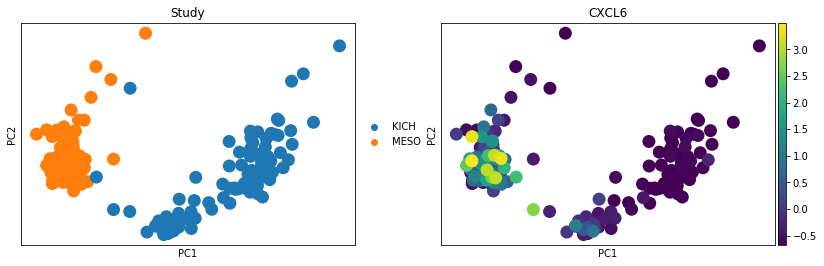

In [51]:
sc.pl.pca(adata, color=['Study', 'CXCL6'], save='_tcga.png')

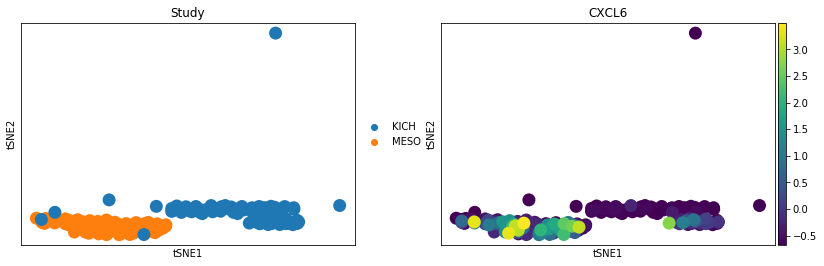

In [52]:
sc.pl.tsne(adata, color=['Study', 'CXCL6'], save='_tcga.png')

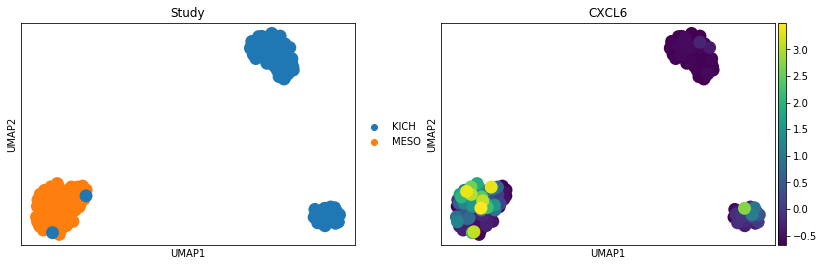

In [53]:
sc.pl.umap(adata, color=['Study','CXCL6'], save='_tcga.png')

# Wrapping up and writing results and figures  back to our bucket.

In [82]:
sc.write(filename='tcga.h5ad', adata=adata)

# if we wanted to continue the analysis we would read in the data as:
# adata = sc.read('tcga.h5ad')


... storing 'EnsemblTranscript' as categorical
... storing 'EnsemblGene' as categorical
... storing 'VegaGeneID' as categorical
... storing 'VegaTranscriptID' as categorical
... storing 'SymbolNum' as categorical
... storing 'GeneFunction' as categorical


In [83]:
!gsutil cp tcga.h5ad umap_tcga.png tsne_tcga.png gs://my-project/scanpy_adatas

AccessDeniedException: 403 The project to be billed is associated with an absent billing account.


In [0]:
# uh oh!